In [2]:
from rasterio.plot import show
import numpy as np
import rasterio
import matplotlib.pyplot as plt

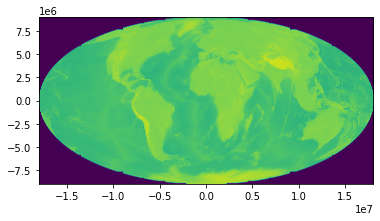

(1668.445988677268, 1668.453704070119)
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 21625, 'height': 10753, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1668.445988677268, 0.0, -18040094.026175868,
       0.0, -1668.453704070119, 8970455.465645315), 'tiled': False, 'interleave': 'band'}


In [3]:
raster_path = 'data/bathymetric_stat/ETOPO1_Ice_g_geotiff_mollweide.tif'
with rasterio.open(raster_path) as src:
    raster_array = src.read(1)
    raster_profile = src.profile
    raster_res = src.res
    show(src)
print(raster_res)
print(raster_profile)

In [4]:
raster_profile.update({'nodata':raster_array[0][0]})
raster_profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768, 'width': 21625, 'height': 10753, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1668.445988677268, 0.0, -18040094.026175868,
       0.0, -1668.453704070119, 8970455.465645315), 'tiled': False, 'interleave': 'band'}

In [5]:
raster_array = np.where(raster_array == raster_profile['nodata'],
                        np.nan, raster_array)

raster_array = np.where(raster_array >= 0,
                        np.nan, raster_array)

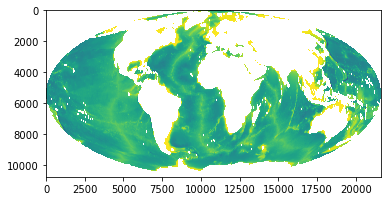

In [6]:
plt.imshow(raster_array)

In [7]:
bsl_array = -raster_array.flatten()
bsl_array = bsl_array[~np.isnan(bsl_array)]

In [8]:
pixcel_area = raster_res[0] * raster_res[1] / 1000000 
sea_area = pixcel_area * bsl_array.size
print(f'sea area is {int(round(sea_area, -6)):,} km^2')

sea area is 362,000,000 km^2


In [9]:
bin_size = 100
zs = list(range(0, int(bsl_array.max()), bin_size))
zs.append(bsl_array.max())

In [10]:
volume_above = []
for z in zs:
    v_sharrow_area = (bsl_array[bsl_array<z] * pixcel_area).sum() / 1000
    v_deep_area = ((z <= bsl_array) * pixcel_area).sum() * z / 1000
    volume_above.append(v_sharrow_area + v_deep_area)

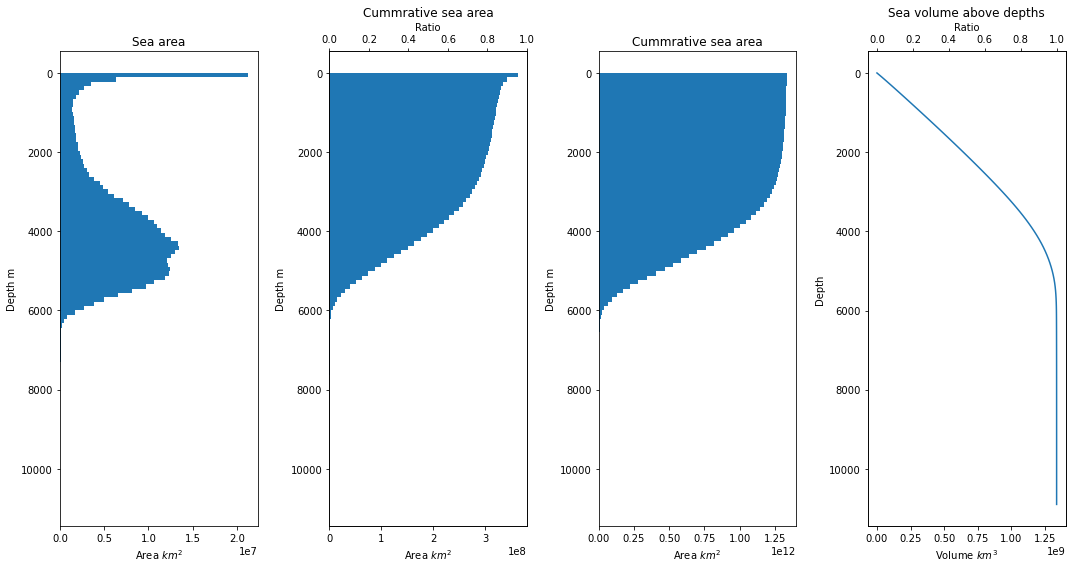

In [19]:
bins = 100
fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(15, 8))
ax[0].hist(bsl_array, bins=bins,
           orientation='horizontal',
           weights=np.zeros_like(bsl_array) + pixcel_area)
ax[0].set_title('Sea area')
ax[0].set_ylabel('Depth m')
ax[0].set_xlabel('Area ' +r'$km^2$')
ax[0].invert_yaxis()

ax[1].hist(bsl_array, bins=bins,
           orientation='horizontal',
           weights=np.zeros_like(bsl_array) + pixcel_area,
           cumulative=-1)
ax[1].set_title('Cummrative sea area')
ax[1].set_ylabel('Depth m')
ax[1].set_xlabel('Area ' +r'$km^2$')
ax[1].invert_yaxis()

ax[2].hist(bsl_array, bins=bins,
           orientation='horizontal',
           weights=(np.zeros_like(bsl_array) + pixcel_area) / 1000,
           cumulative=-1)
ax[2].set_title('Sea volume at depth')
ax[2].set_ylabel('Depth m')
ax[2].set_xlabel('Vlolume ' +r'$km^3$')
ax[2].invert_yaxis()

ax[3].plot(volume_above, zs)
ax[3].set_title('Sea volume above depths')
ax[3].set_ylabel('Depth')
ax[3].set_xlabel('Volume ' + r'$km^3$')
ax[3].invert_yaxis()

ax_scale0 = ax[1].twiny()
ax_scale0.set_xlim(0, 1)
ax_scale0.set_xlabel('Ratio')
ax_scale1 = ax[3].twiny()
ax_scale1.set_xlim((ax[3].get_xlim()[0]/((bsl_array/1000 * pixcel_area).sum())), 
                   (ax[3].get_xlim()[1]/((bsl_array/1000 * pixcel_area).sum())))
ax_scale1.set_xlabel('Ratio')

plt.show()

In [76]:
bsl_count_histo, bin_edges = np.histogram(bsl_array, bins=100)
bsl_area_histo = bsl_count_histo * pixcel_area
bsl_area_cumm = np.flip(np.cumsum(np.flip(bsl_area_histo)))
bin_widths = np.diff(bin_edges)
bsl_volume_above = np.cumsum(bsl_area_cumm) * bin_widths / 1000
bins = bin_edges[:-1] + (bin_widths/2)

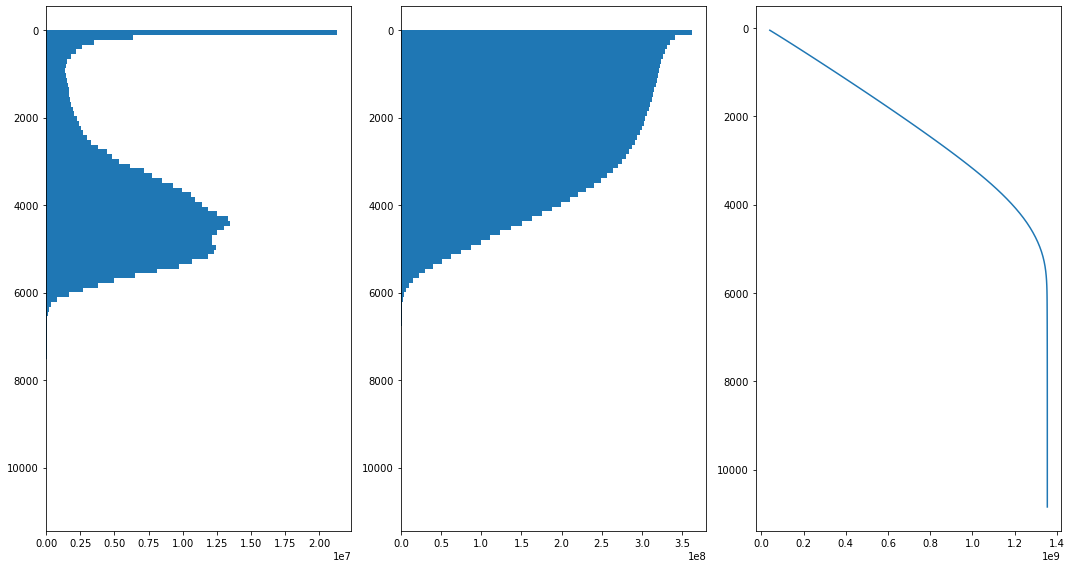

In [78]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(15, 8))
ax[0].barh(y=bins, width=bsl_area_histo, height=bin_widths)
ax[0].invert_yaxis()
ax[1].barh(y=bins, width=bsl_area_cumm, height=bin_widths)
ax[1].invert_yaxis()
ax[2].plot(bsl_volume_above, bins)
ax[2].invert_yaxis()


ax1_scale_rate = ax[1].twiny()
ax1_scale_rate.set_xlim(ax[1].get_xlim()[0], ax[1].get_xlim()[0])
# ax_scale1.set_xlabel('Ratio')
# ax_scale1 = ax[3].twiny()
# ax_scale1.set_xlim((ax[3].get_xlim()[0]/((bsl_array/1000 * pixcel_area).sum())), 
#                    (ax[3].get_xlim()[1]/((bsl_array/1000 * pixcel_area).sum())))
# ax_scale1.set_xlabel('Ratio')


plt.show()

In [18]:
bsl_range = (0, 4000)
# bsl_range = (0, 2000)
total_volume = (bsl_array * pixcel_area).sum() / 1000
print(f'Total volume is {int(round(total_volume, -6)):,} km^3')
water_range_array_tmp = bsl_array[bsl_range[0] < bsl_array] - bsl_range[0]
water_range_array = np.where(water_range_array_tmp < (bsl_range[1] - bsl_range[0]),
                             water_range_array_tmp,
                             bsl_range[1] - bsl_range[0])
water_range_volume = (water_range_array * pixcel_area).sum() / 1000

print(f'Sea volume from {bsl_range[0]:,} m b.s.l. to {bsl_range[1]:,} m b.s.l. '\
      f'is {int(round(water_range_volume)):,} km^3')
print(f'Ratio: {round(water_range_volume/total_volume, 4)}')

Total volume is 1,336,000,000 km^3
Sea volume from 0 m b.s.l. to 4,000 m b.s.l. is 1,169,180,929 km^3
Ratio: 0.8754
